In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Get column names
measure_first_row = session.query(Measurement).first()
col_1 = measure_first_row.__dict__
measurement_col = []

for key in col_1:
    if key != "_sa_instance_state":
        measurement_col.append(key)

measurement_col

station_first_row = session.query(Station).first()
col_2 = station_first_row.__dict__
station_col = []

for key in col_2:
    if key != "_sa_instance_state":
        station_col.append(key)

station_col

['station', 'name', 'longitude', 'id', 'latitude', 'elevation']

In [11]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date

'2017-08-23'

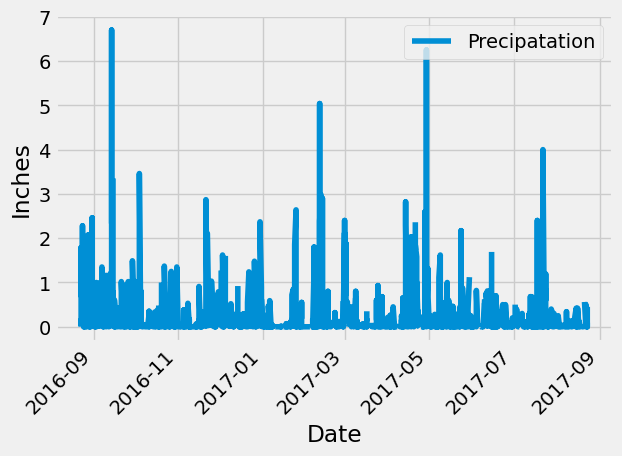

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date_1_str = latest_date
date_1 = dt.datetime.strptime(date_1_str, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
date_2_str = str(date_1 - dt.timedelta(days=365))


# Perform a query to retrieve the data and precipitation scores
query_1 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date.between(date_2_str,date_1_str)).\
            order_by(Measurement.date).all()

date, precip = zip(*query_1)


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame({"Date": date, "Precipatation": precip})
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)


# Sort the dataframe by date
df_sort = df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
df_sort["Precipatation"].plot(legend=True)
plt.legend(loc="upper right")
plt.xticks(rotation = 45 )
plt.xlabel("Date")
plt.ylabel("Inches")
plt.grid(True)
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_sort.describe()

,Precipatation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Measurement.station).group_by(Measurement.station).count()
total_stations

9

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()

active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

most_active

[(54.0, 85.0, 71.66378066378067)]

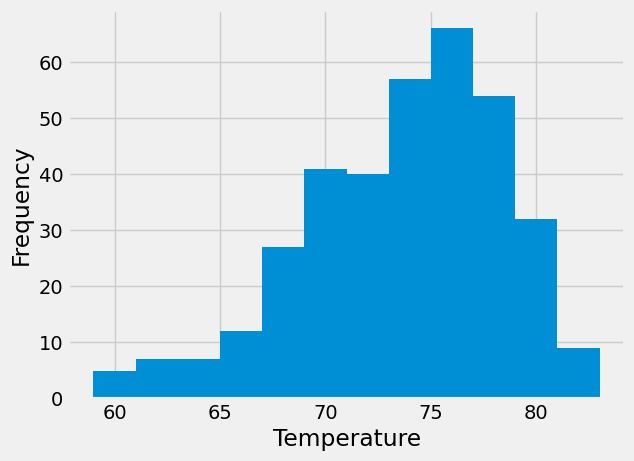

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_last_date = (session.query(func.max(Measurement.date))
 .filter(Measurement.station == 'USC00519281')
 .scalar())

station_last_date = dt.datetime.strptime(station_last_date, '%Y-%m-%d').date()

year_prior = str(station_last_date - dt.timedelta(days=365))

query_2 = session.query(Measurement.tobs).\
        filter(Measurement.station == 'USC00519281').filter(Measurement.date >= year_prior).\
        all()

temp = [temp[0] for temp in query_2]

df = pd.DataFrame(temp) 

plt.hist(df, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")

plt.show()


# Close Session

In [216]:
# Close Session
session.close()